# Algorithm Walkthrough with Dummy Example

In [1]:
# Import packages.
import sys
import numpy as np
import time
import gzip
import shutil
import re
import support_code as supp

try:
    logaddexp = np.logaddexp
except AttributeError:
    def logaddexp(logx, logy):
        if logy - logx > 100:
            return logy
        elif logx - logy > 100:
            return logx
        minxy = min(logx, logy)
        return minxy + np.log(np.exp(logx - minxy) + np.exp(logy - minxy))

# Print versions of our libraries.
print('numpy', np.__version__)
print('gzip', np.__version__)
print('shutil', np.__version__)
print('re', np.__version__)

numpy 1.22.3
gzip 1.22.3
shutil 1.22.3
re 1.22.3


### Introduction and Assumptions

This Hidden Markov Model will give the probability of being in state $S_i$ at locus $T$, given:
- the HMM $\lambda$, representing Pruf'ers assumed parameters
- the observed sequence $O$, comprised of the state space $i$ $\in$ {C,N}. It is a string of labels representing 500bp locus "bins" in a genome that are Consistent (C) or Not Consistent (N) with a history of introgression.
- the locus position $t$ in the sequence $1 \le t < T$, where $T$ is the length of the sequence

To understand how the HMM functions, consider the observed sequence `NNCCN` ($T = 5$) with the underlying true states `SSIIS` and the default HMM $\lambda$ outlined in Prufer et al. (2014), whose assumptions are as follows:
- **Transition probability between ancestries ($s$) is 0.0005 Morgans.** The authors expected very small segments of shared haplotypes due to being broken up by millennia of recombiantion. Assuming a constant recombination rate across chromosomes, the expected length of 2,000-generation-old admixture would be 1/2000 or 0.0005 Morgans.
- **Probability of archaic ancestry at any locus ($p$) is 0.01.** This number corresponds to a Neanderthal admixture proportion of 1%, which is conservatively at the low end of the range of what has previously been reported.
- **Probability of archaic ancestry in a "C"-labeled locus and Probability of modern human ancestry in an "N"-labeled locus ($u$) is 0.99.** This allows for some probability of a test haplotype not being introgressed even if locally it is a clade with an archaic haplotype due to incomplete lineage sorting.

`Ob` represents the full observed sequence `NNCCN`, which must be binary-encoded to facilitate B-matrix referencing, which means is is turned into the string `00110`.

In [170]:
# Setting up parameters

# PRUFER
s = .0005 # Ancestral switch rate
p = 0.01 # Prior probability for archaic ancestry at any locus (initial distribution)
u = 0.99 # Prior probability of archaic ancestry conditional on all SNPs in the window being of state "C"
threshold = .9 # Probability cutoff for HMM's "guess" at a true state (must be above 90%)
N = 2 # State space (State 0 = 'S' (Species/sapiens), State 1 = 'I' (Introgressed/neandertalensis))
M = 2 # Observation space (Observation 0 = 'N' (not consistent), Observation 1 = 'C' (consistent))
# SIMPLIFIED
# s = .25 # Ancestral switch rate
# p = 0.25 # Prior probability for archaic ancestry at any locus (initial distribution)
# u = 0.9 # Prior probability of archaic ancestry conditional on all SNPs in the window being of state "C"
# threshold = .9 # Probability cutoff for HMM's "guess" at a true state (must be above 90%)
# N = 2 # State space (State 0 = 'S' (Species/sapiens), State 1 = 'I' (Introgressed/neandertalensis))
# M = 2 # Observation space (Observation 0 = 'N' (not consistent), Observation 1 = 'C' (consistent))









# Setting up other parameters
normalized = False # Does not normalize results based on relative probability
optimization_limit = 0 # Primary Baum-Welch adjustment parameter, to make sure it doesn't overfit
observed_sequence = "NNCCN"
# index letter observations for future use
observations = ['N', 'C']
# Ob is the same as the observation sequence, but with 'N'-> 0 and 'C'-> 1 for quick referencing.
Ob = [observations.index(label) for label in observed_sequence]
# sequence length
T = len(Ob)

---
### Visualization of Prufer's HMM
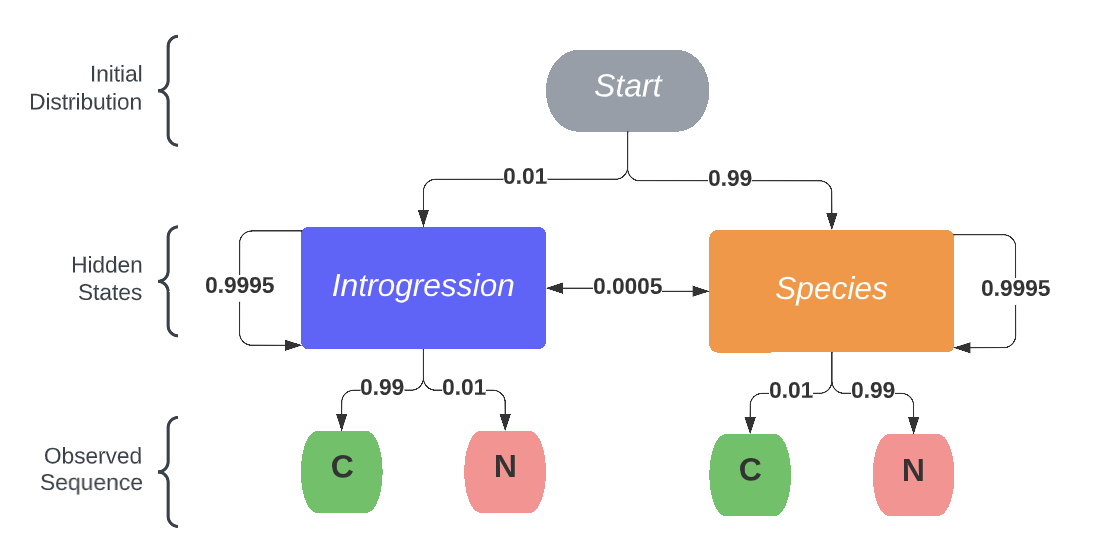

---
### Mathematical Representation of $\lambda$

| A | Species | Introgressed |
| :--- | --- | --- |
| Species | 99.95% | 0.05% |
| Introgressed | 0.05% | 99.95% |

| B | N | C |
| :--- | --- | --- |
| Species | 99% | 1% |
| Introgressed | 1% | 99% |

| pi | Species | Introgressed |
| :--- | --- | --- |
| Start | 99% | 1% |

In [171]:
# All calculations are done in log-space to prevent point-underflows

# Transition Probabilities (2x2)
A = np.array(((1 - s, s), (s, 1 - s)))
lp_A = np.log(A)

# Emission Probabilities (2x2)
B = np.array(((u, 1 - u), (1 - u, u)))
lp_B = np.log(B)

# Initial State Distribution (2x1)
pi = np.array((1 - p, p))
lp_pi = np.log(pi)

print(A)
print('---')
print(B)
print('---')
print(pi)

[[9.995e-01 5.000e-04]
 [5.000e-04 9.995e-01]]
---
[[0.99 0.01]
 [0.01 0.99]]
---
[0.99 0.01]


---
### The Forward Algorithm and the $\alpha$ Matrix

To learn about the purpose, input, and output of `calc_alpha()`, as well the commented code, refer to `1_rep_outline_workflow.ipynb`.

To find a line-by-line breakdown of the code, refer to the overleaf document `HMM-Ancestral-Inference`.

#### $\alpha$ Matrix Template for `NNCCN`

| Prefix Length | Prefix | State 0 (ends in `Species`) | State 1 (ends in `Introgressed`) |
| --- | --- | --- | --- |
| t=0 | No characters | P(first state is `S`) | P(first state is `I`) |
| t=1 |`N` | P(ends at state `S` \| Prefix `N`) | P(ends at state `I` \| Prefix `N`) |
| t=2 |`NN` | P(ends at state `S` \| Prefix `NN`) | P(ends at state `I` \| Prefix `NN`) |
| t=3 |`NNC` | P(ends at state `S` \| Prefix `NNC`) | P(ends at state `I` \| Prefix `NNC`) |
| t=4 |`NNCC` | P(ends at state `S` \| Prefix `NNCC`) | P(ends at state `I` \| Prefix `NNCC`) |
| T=4 |`NNCCN` | P(ends at state `S` \| Prefix `NNCCN`) | P(ends at state `I` \| Prefix `NNCCN`) |

In [172]:
def calc_alpha(A, B, pi, Ob, N, T):
    alpha = np.zeros((T + 1, N))
    alpha[0, :] = pi
    for t in range(1, T + 1):
        k = Ob[t - 1]
        for j in range(N):
            lprob = np.NINF
            for i in range(N):
                lp = alpha[t - 1][i] + A[i][j] + B[i][k]
                lprob = logaddexp(lprob, lp)
            alpha[t][j] = lprob
    return alpha

In [173]:
# showing 3 nearest decimal places
np.set_printoptions(precision=10)
alpha = calc_alpha(lp_A, lp_B, lp_pi, Ob, N, T)
np.exp(alpha)

array([[9.9000000000e-01, 1.0000000000e-02],
       [9.7961000000e-01, 5.9000000000e-04],
       [9.6932899600e-01, 4.9080400000e-04],
       [9.6886862630e-03, 4.9049965700e-04],
       [9.7081216529e-05, 4.8540030653e-04],
       [9.6064776163e-05, 4.8996312660e-06]])

Note that combining the last two cells in the $\alpha$ matrix gives the total likelihood that the observed sequence was generated by the HMM $\lambda$.

---
### The Backward Algorithm and the $\beta$ Matrix

To learn about the purpose, input, and output of `calc_beta()`, as well the commented code, refer to `1_rep_outline_workflow.ipynb`.

To find a line-by-line breakdown of the code, refer to the overleaf document `HMM-Ancestral-Inference`.

#### $\beta$ Matrix Template  for `NNCCN`

| Suffix Length | Suffix | State 0 (came from `Species`) | State 1 (came from `Introgressed`) |
| --- | --- | --- | --- |
| t=0 |`NNCCN`| P(Sequence `NNCCN` \| from `S`) | P(Sequence `NNCCN` \| from `I`) |
| t=1 |`NCCN`| P(Sequence `NCCN` \| from `S`) | P(Sequence `NCCN` \| from `I`) |
| t=2 |`CCN`| P(Sequence `CCN` \| from `S`) | P(Sequence `CCN` \| from `I`) |
| t=3 |`CN`| P(Sequence `CN` \| from `S`) | P(Sequence `CN` \| from `I`) |
| t=4 |`N` | P(Sequence `N` \| from `S`) | P(Sequence `N` \| from `I`) |
| T=5 |No Characters | 1 | 1 |

In [174]:
def calc_beta(A, B, Ob, N, T):
    beta = np.zeros((T + 1, N))
    for t in range(T - 1, -1, -1):
        k = Ob[t]
        for j in range(N):
            lprob = np.NINF
            for i in range(N):
                lp = beta[t + 1][i] + A[j][i] + B[j][k]
                lprob = logaddexp(lprob, lp)
            beta[t][j] = lprob
    return beta

In [175]:
beta = calc_beta(lp_A, lp_B, Ob, N, T)
np.exp(beta)

array([[1.0197387020e-04, 1.0275927667e-06],
       [1.0300403174e-04, 1.0275915424e-04],
       [9.8953450000e-05, 1.0281006450e-02],
       [9.8951000000e-03, 1.0385100000e-02],
       [9.9000000000e-01, 1.0000000000e-02],
       [1.0000000000e+00, 1.0000000000e+00]])

---
### The $\xi$ Matrix

To learn about the purpose, input, and output of `calc_xi()`, as well the commented code, refer to `1_rep_outline_workflow.ipynb`.

To find a line-by-line breakdown of the code, refer to the overleaf document `HMM-Ancestral-Inference`.

#### $\xi$ Matrix Template for `NNCCN`

$\xi$ (Front Side):

| Transition Start | Observed Transition | State `S` went to State `S` | State `S` went to State `I` |
| :--- | :--- | :--- | :--- |
| t=0 | `N` $\Rightarrow$ `N` | P(`S` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `N`) | P(`S` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `N`) |
| t=1 | `N` $\Rightarrow$ `C` | P(`S` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `C`) | P(`S` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `C`) |
| t=2 | `C` $\Rightarrow$ `C` | P(`S` $\Rightarrow$ `S` \| `C`$\Rightarrow$ `C`) | P(`S` $\Rightarrow$ `I` \| `C`$\Rightarrow$ `C`) |
| t=3 | `C` $\Rightarrow$ `N` | P(`S` $\Rightarrow$ `S` \| `C`$\Rightarrow$ `N`) | P(`S` $\Rightarrow$ `I` \| `C`$\Rightarrow$ `N`) |
| t=4 | `N` $\Rightarrow$ `end` | P(`S` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `end`) | P(`S` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `end`) 

$\xi$ (Back Side):

| Transition Start | Observed Transition | State `I` went to State `S` | State `I` went to State `I` |
| :--- | :--- | :--- | :--- |
| t=0 | `N` $\Rightarrow$ `N` | P(`I` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `N`) | P(`I` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `N`) |
| t=1 | `N` $\Rightarrow$ `C` | P(`I` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `C`) | P(`I` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `C`) |
| t=2 | `C` $\Rightarrow$ `C` | P(`I` $\Rightarrow$ `S` \| `C`$\Rightarrow$ `C`) | P(`I` $\Rightarrow$ `I` \| `C`$\Rightarrow$ `C`) |
| t=3 | `C` $\Rightarrow$ `N` | P(`I` $\Rightarrow$ `S` \| `C`$\Rightarrow$ `N`) | P(`I` $\Rightarrow$ `I` \| `C`$\Rightarrow$ `N`) |
| t=4 | `N` $\Rightarrow$ `end` | P(`I` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `end`) | P(`I` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `end`) 

In [176]:
def calc_xi(A, B, Ob, N, T, alpha, beta):
    xi = np.zeros((T, N, N))
    for t in range(T):
        k = Ob[t]
        lp_traverse = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                lp = (
                        alpha[t][i]
                        + A[i][j]
                        + B[i][k]
                        + beta[t + 1][j]
                )
                lp_traverse[i][j] = lp
        xi[t, :, :] = lp_traverse - supp.logsum(lp_traverse)
    return xi

In [177]:
xi = calc_xi(lp_A, lp_B, Ob, N, T, alpha, beta)
np.exp(xi)

array([[[9.9939946113e-01, 4.9876114579e-04],
        [5.1010070954e-08, 1.0172671466e-04]],

       [[9.5002239393e-01, 4.9377118210e-02],
        [2.8912434088e-09, 6.0048496921e-04]],

       [[9.4952387567e-01, 4.9852115279e-04],
        [2.3810317102e-05, 4.9953792862e-02]],

       [[9.4954288792e-01, 4.7980701862e-06],
        [2.3807335975e-03, 4.8071580417e-02]],

       [[9.5144765970e-01, 4.7596181076e-04],
        [2.4038189244e-05, 4.8052340298e-02]]])

---
### The $\gamma$ Matrix

To learn about the purpose, input, and output of `calc_gamma()`, as well the commented code, refer to `1_rep_outline_workflow.ipynb`.

To find a line-by-line breakdown of the code, refer to the overleaf document `HMM-Ancestral-Inference`.

#### $\gamma$ Matrix Template for `NNCCN`

$\gamma$ (Front Side):

| Sequence Position | Locus Label | Chance of Species ancestry | Chance of Introgressed ancestry |
| :--- | :--- | :--- | :--- |
| t=0 | `N` | P(`S` \| `N`) | **P(`I` \| `N`)** |
| t=1 | `N` | P(`S` \| `N`) | **P(`I` \| `N`)** |
| t=2 | `C` | P(`S` \| `C`) | **P(`I` \| `C`)** |
| t=3 | `C` | P(`S` \| `C`) | **P(`I` \| `C`)** |
| t=4 | `N` | P(`S` \| `N`) | **P(`I` \| `N`)** |

In [178]:
def calc_gamma(xi, N, T):
    gamma = np.zeros((T, N))
    for t in range(T):
        for i in range(N):
            gamma[t][i] = supp.logsum(xi[t, i, :])
    return gamma

In [179]:
gamma = calc_gamma(xi, N, T)
np.exp(gamma)

array([[9.9989822228e-01, 1.0177772474e-04],
       [9.9939951214e-01, 6.0048786045e-04],
       [9.5002239682e-01, 4.9977603179e-02],
       [9.4954768599e-01, 5.0452314015e-02],
       [9.5192362151e-01, 4.8076378487e-02]])

---
### The Baum-Welch Algorithm

The Baum-Welch algorithm is an iterative method that adjusts the HMM parameters to infer the characteristics of sequences and to better detect hidden states. Mathematically, this adjustment involves tuning the $\lambda = (A, B, \pi$) until some $\lambda' = (A', B', \pi')$ which localizes $P(O\|\lambda)$, or the probability of seeing the sequence $O$ given the underlying assumptions $\lambda$ of the HMM. The Baum-Welch algorithm guarantees convergence to a desired threshold by constraining optimization ("re-estimation") of the parameters $(A, B, \pi)$ using properties of Lagrangian multipliers.

To learn about the purpose, input, and output of the $\lambda$-updating functions, as well the commented code, refer to `1_rep_outline_workflow.ipynb`.





In [180]:
def update_A(N, xi, gamma):
    A = np.zeros((N, N))
    trans_out = np.zeros(N)
    for i in range(N):
        trans_out[i] = supp.logsum(gamma[:, i])
    for i in range(N):
        for j in range(N):
            A[i][j] = supp.logsum(xi[:, i, j]) - trans_out[i]
    return A

In [181]:
def update_B(Ob, N, M, T, xi):
    B = np.zeros((N, M))
    for i in range(N):
        ksum = np.zeros(M) + np.NINF
        for t in range(T):
            k = Ob[t]
            for j in range(N):
                ksum[k] = logaddexp(ksum[k], xi[t, i, j])
        ksum = ksum - supp.logsum(ksum)
        B[i, :] = ksum
    return B

In [182]:
def update_pi(N, gamma):
    pi = np.zeros(N)
    for i in range(N):
        pi[i] = gamma[0][i]
    return pi

In [183]:
# Initialize the count
optimization_count = 0
# If the algorithm doesn't achieve convergence before this many steps, stop it manually
optimization_limit = 20
# Log-likelihood convergence threshold - used to tell when Baum-Welch has gone far enough
convergence_threshold = 0.01
# Store the probabilities from each optimization step in order to compare them later
# All_gammas has the strucutre [algorithm step number] -> gamma matrix
All_gammas = {}

# Initialize log-likelihood trackers and and initial inference
logP_old = np.NINF
logP_new = supp.logsum(alpha[T, :])

# Iterate until convergence is reached between results, performance decreases, or the hard cap is met
while logP_new - logP_old > convergence_threshold and optimization_count < optimization_limit:

    # calculate variables / fill out matrices
    bw_alpha = calc_alpha(lp_A, lp_B, lp_pi, Ob, N, T)
    bw_beta = calc_beta(lp_A, lp_B, Ob, N, T)
    bw_xi = calc_xi(lp_A, lp_B, Ob, N, T, bw_alpha, bw_beta)
    bw_gamma = calc_gamma(bw_xi, N, T)

    # recording optimization count / performance progress
    if optimization_count >= 1:
        print("Optimization count " + str(optimization_count))
        print("Improvement of " + str(np.exp(logP_new - logP_old)) + " from last model")
        All_gammas[optimization_count] = bw_gamma
    # we set it to just run once
    elif optimization_count == 0:
        All_gammas[optimization_count] = gamma

    # once variables have been calculated and progress displayed, the counter ticks up
    optimization_count += 1

    # update lambda, the underlying assumptions of the HMM
    new_A = update_A(N, bw_xi, bw_gamma)
    new_B = update_B(Ob, N, M, T, bw_xi)
    new_pi = update_pi(N, bw_gamma)

    # recalculate the forward variable (alpha matrix) from the new lambda
    bw_alpha = calc_alpha(new_A, new_B, new_pi, Ob, N, T)

    # continue iterating only if performance improves, or
    # the likelihood of seeing this sequence given this new HMM increases
    logP_old = logP_new
    # compares last two probabilities of the alpha matrix (%chance of seeing the complete prefix)
    # to the old log-probability of seeing the complete prefix given the HMM parameters
    if supp.logsum(bw_alpha[T, :]) > logP_old:
        lp_A, lp_B, lp_pi = new_A, new_B, new_pi
        logP_new = supp.logsum(bw_alpha[T, :])

Optimization count 1
Improvement of 341.8659191597012 from last model


In [184]:
print('Naive HMM')
print(np.exp(All_gammas[0]))
print('1 Step of Baum-Welch')
print(np.exp(All_gammas[1]))

Naive HMM
[[9.9989822228e-01 1.0177772474e-04]
 [9.9939951214e-01 6.0048786045e-04]
 [9.5002239682e-01 4.9977603179e-02]
 [9.4954768599e-01 5.0452314015e-02]
 [9.5192362151e-01 4.8076378487e-02]]
1 Step of Baum-Welch
[[9.9995279361e-01 4.7206389871e-05]
 [9.9092912171e-01 9.0708782942e-03]
 [9.7429771135e-01 2.5702288648e-02]
 [9.6512319970e-01 3.4876800298e-02]
 [9.6070166314e-01 3.9298336864e-02]]


In [185]:
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns

In [186]:
def compare_3(naive_gamma, bw_gamma, true_intro_states):
    ng = naive_gamma[:, 1]
    bw = bw_gamma[:, 1]
    tis = true_intro_states

    x_axis_start = 1
    x_axis_end = 5
    tis = np.array((0, 0, 1, 1, 0))
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(12, 9), dpi=100)
    ax = fig.add_subplot(111)
    ax.plot(np.linspace(x_axis_start, x_axis_end, tis.shape[0]), tis, marker='.', color='tab:orange')
    ax.plot(np.linspace(x_axis_start, x_axis_end, ng.shape[0]), ng, marker='.', color='tab:blue')
    ax.plot(np.linspace(x_axis_start, x_axis_end, bw.shape[0]), bw, marker='.', color='tab:green')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Observed Sequence: NNCCN')

    fig.supxlabel('Character in Sequence', size=14, weight='bold')
    fig.supylabel('HMM Confidence Locus is Introgressed', size=14, weight='bold')
    fig.suptitle('Naive HMM vs Baum-Welch HMM', weight='bold')
    fig.tight_layout()
    plt.legend(["Hidden States", "Naive HMM", "Baum-Welch HMM"], loc="upper left")
    # plt.savefig('/Users/briankirz/Downloads/gamma_test.png', facecolor='white', dpi=300)


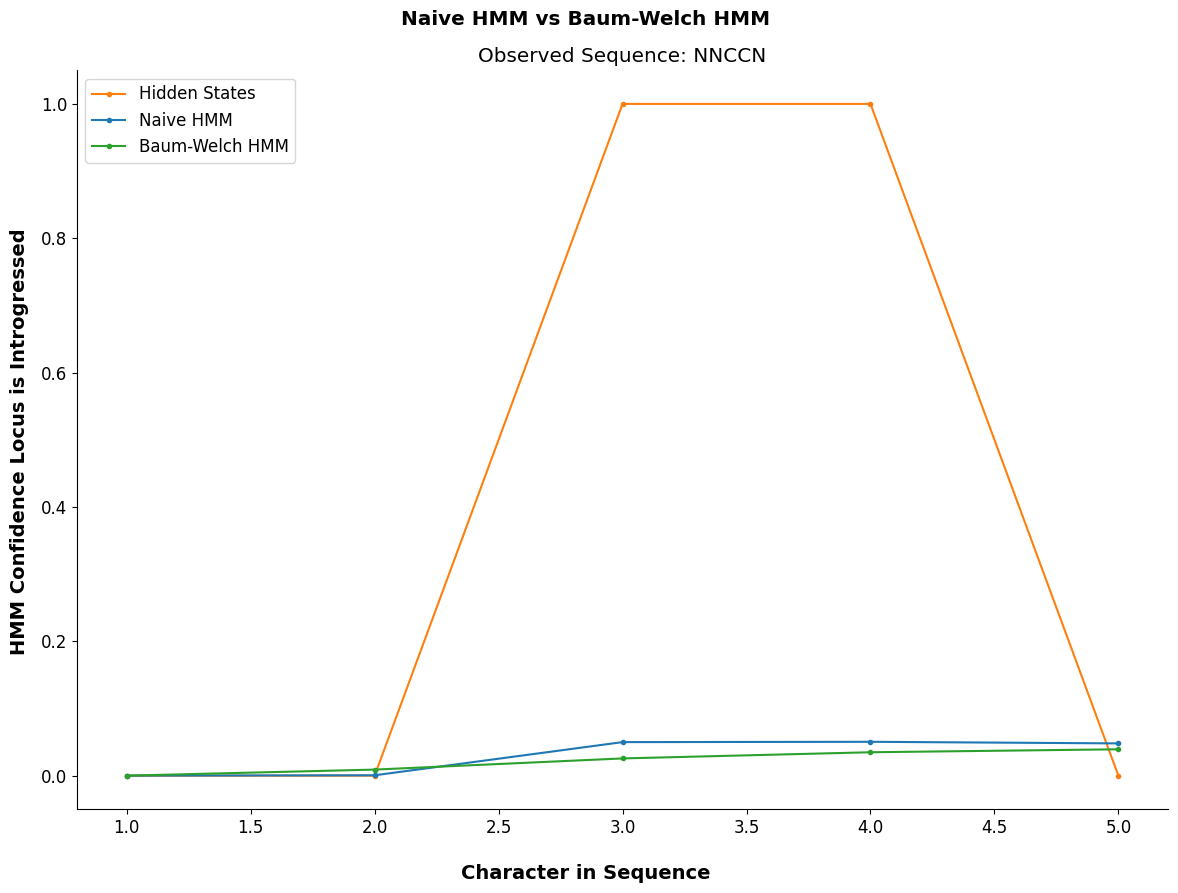

In [187]:
true_intro_windows = [0, 0, 1, 1, 0]
tiw = np.array([true_intro_windows]).T
tiw

compare_3(np.exp(All_gammas[0]), np.exp(All_gammas[1]), tiw)